In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('seaborn')
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
import tensorflow as tensorflow
from keras.models import Sequential
from keras.layers import Dense, Dropout
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from keras.utils.vis_utils import plot_model

<ipython-input-1-25765f9f6760>:4: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


In [3]:
df = pd.read_csv('/content/flood.csv')
df.head(10)

,temp,max_temp,wind_speed,cloudcover,precip,humidity,class
0,29.90,37.00,23.00,58.60,146.00,83.86,1
1,93.04,82.41,63.44,102.42,192.07,129.30,1
2,87.13,98.82,72.29,122.12,191.80,142.25,1
3,92.12,72.39,73.84,96.50,196.53,150.42,1
4,92.64,76.03,67.13,92.61,191.76,126.61,1
5,73.27,95.88,79.40,103.24,182.90,126.45,1
6,80.92,84.23,63.86,123.63,209.87,118.69,1
7,87.50,83.77,72.50,120.16,203.12,122.66,1
8,91.64,78.80,85.94,94.79,190.01,128.72,1
9,89.59,96.45,68.27,113.78,193.94,148.81,1


In [5]:
# Separate the dataset into two classes
class_a = df[df['class'] == 0]
class_b = df[df['class'] == 1]

# Count the number of rows in each class
num_class_a = len(class_a)
num_class_b = len(class_b)

# Determine the smaller class size
min_class_size = min(num_class_a, num_class_b)

# Randomly sample min_class_size number of rows from both classes
class_a_sampled = class_a.sample(n=(int)(min_class_size*0.8), random_state=42)
class_b_sampled = class_b.sample(n=(int)(min_class_size*0.8), random_state=42)

# Combine the sampled rows from both classes to create the training dataset
training_dataset = pd.concat([class_a_sampled, class_b_sampled])

# Remove the sampled rows from both classes to create the remaining data
class_a_remaining = class_a.drop(class_a_sampled.index)
class_b_remaining = class_b.drop(class_b_sampled.index)

# Combine the remaining rows from both classes to create the test dataset
test_dataset = pd.concat([class_a_remaining, class_b_remaining])

# Split the training dataset into features (X_train) and labels (y_train)
X_train = training_dataset.drop('class', axis=1)
y_train = training_dataset['class']

# Split the test dataset into features (X_test) and labels (y_test)
X_test = test_dataset.drop('class', axis=1)
y_test = test_dataset['class']


In [6]:
features = df.drop(['class'], axis = 1)
labels = df['class'].values.reshape(-1, 1)
# X_train, X_test, y_train, y_test = train_test_split(features,labels, test_size = 0.2,stratify = labels, random_state = 42)

In [7]:
# fitting scaler
sc_features = StandardScaler()
# transforming features
X_test = sc_features.fit_transform(X_test)
X_train = sc_features.transform(X_train)
# features
X_test = pd.DataFrame(X_test, columns = features.columns)
X_train = pd.DataFrame(X_train, columns = features.columns)
# labels
y_test = pd.DataFrame(y_test, columns = ['class'])
y_train = pd.DataFrame(y_train, columns = ['class'])
X_train.head()

,temp,max_temp,wind_speed,cloudcover,precip,humidity
0,1.106071,0.582174,0.258119,-0.828680,-1.086654,-0.459964
1,-2.993891,-2.938572,-2.335506,-2.958926,-1.187194,-3.940063
2,-0.287172,-0.206721,-0.583100,0.461107,-1.076003,0.707602
3,0.316389,1.416468,0.392671,-1.562221,-1.065873,-2.024103
4,-0.101716,1.796769,-0.887726,-1.931698,-1.042410,-1.605818


In [8]:
import pickle
with open('flood_scaler.pkl', 'wb') as f:
  pickle.dump(sc_features, f)

In [25]:
model = Sequential()
# input layer + 1st hidden layer
model.add(Dense(128, input_dim=6, activation='relu'))
# 2nd hidden layer
model.add(Dense(64, activation='relu'))
# output layer
model.add(Dense(16, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(16, activation='relu'))
model.add(Dense(1, activation = 'sigmoid'))
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_22 (Dense)            (None, 128)               896       
                                                                 
 dense_23 (Dense)            (None, 64)                8256      
                                                                 
 dense_24 (Dense)            (None, 16)                1040      
                                                                 
 dropout_5 (Dropout)         (None, 16)                0         
                                                                 
 dense_25 (Dense)            (None, 16)                272       
                                                                 
 dense_26 (Dense)            (None, 1)                 17        
                                                                 
Total params: 10,481
Trainable params: 10,481
Non-trai

In [26]:
# Compile Model
model.compile(optimizer = 'adam', metrics=['accuracy'], loss ='binary_crossentropy')
model_path = "flood_5.h5"

# Define the ModelCheckpoint callback
checkpoint_callback = ModelCheckpoint(model_path, monitor='accuracy', save_best_only=True, mode='max', verbose=1)
# Train Model
history = model.fit(X_train, y_train, validation_data = (X_test, y_test), batch_size = 10, epochs = 30, callbacks=[checkpoint_callback])

Epoch 1/30
323/327 [============================>.] - ETA: 0s - loss: 0.1959 - accuracy: 0.9285
Epoch 1: accuracy improved from -inf to 0.92831, saving model to flood_5.h5
327/327 [==============================] - 4s 5ms/step - loss: 0.1953 - accuracy: 0.9283 - val_loss: 0.1503 - val_accuracy: 0.9403
Epoch 2/30
320/327 [============================>.] - ETA: 0s - loss: 0.0807 - accuracy: 0.9681
Epoch 2: accuracy improved from 0.92831 to 0.96814, saving model to flood_5.h5
327/327 [==============================] - 2s 6ms/step - loss: 0.0800 - accuracy: 0.9681 - val_loss: 0.1001 - val_accuracy: 0.9600
Epoch 3/30
321/327 [============================>.] - ETA: 0s - loss: 0.0611 - accuracy: 0.9769
Epoch 3: accuracy improved from 0.96814 to 0.97702, saving model to flood_5.h5
327/327 [==============================] - 2s 7ms/step - loss: 0.0609 - accuracy: 0.9770 - val_loss: 0.1118 - val_accuracy: 0.9645
Epoch 4/30
317/327 [============================>.] - ETA: 0s - loss: 0.0531 - accura

In [13]:
import tensorflow as tf
from sklearn.metrics import confusion_matrix

# Assuming you have test features as 'X_test'
predictions = model.predict(X_test)
predicted_labels = predictions # Get the predicted labels as the class with the highest probability

predicted_labels = predicted_labels
binary_labels = np.where(predictions > 0.5, 1, 0)
true_labels = y_test  # Assuming y_test is a TensorFlow tensor
confusion_matrix_np = confusion_matrix(true_labels, binary_labels)

print(confusion_matrix_np)

56/56 [==============================] - 0s 1ms/step
[[ 399    9]
 [  20 1348]]


In [14]:
# Assuming you have test features as 'X_test'
predictions = model.predict(X_train)
predicted_labels = predictions # Get the predicted labels as the class with the highest probability

predicted_labels = predicted_labels
binary_labels = np.where(predictions > 0.5, 1, 0)
true_labels = y_train  # Assuming y_test is a TensorFlow tensor
confusion_matrix_np = confusion_matrix(true_labels, binary_labels)

print(confusion_matrix_np)

102/102 [==============================] - 0s 2ms/step
[[1624    8]
 [  14 1618]]


In [15]:
_, train_acc = model.evaluate(X_train, y_train, verbose=0)
_, valid_acc = model.evaluate(X_test, y_test, verbose=0)
print('Train: %.3f, Valid: %.3f' % (train_acc, valid_acc))

Train: 0.993, Valid: 0.984


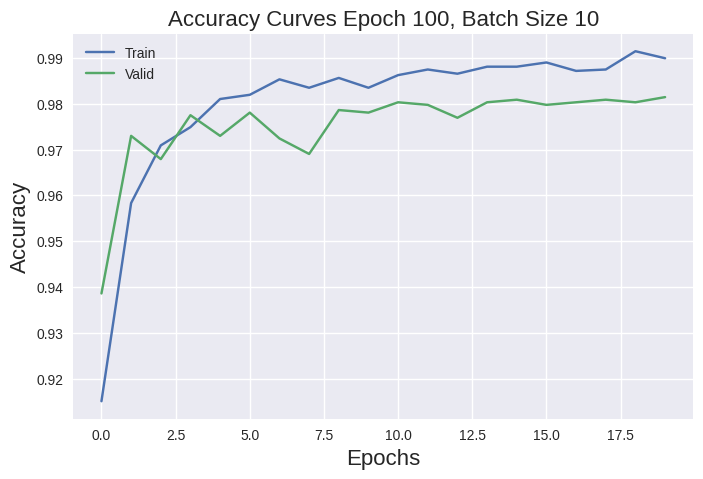

In [19]:
plt.figure(figsize=[8,5])
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Valid')
plt.legend()
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Accuracy', fontsize=16)
plt.title('Accuracy Curves Epoch 100, Batch Size 10', fontsize=16)
plt.show()

In [24]:
from joblib import dump, load

dump(sc_features, 'flood_scalar.bin')

scalar = load('flood_scalar.bin')